In [1]:
%load_ext autoreload
%autoreload 2

In [59]:
import networkx as nx
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import copy
from scipy.linalg import *
from model_function import *
import pickle
import random

In [3]:
def draw_graph(Graph, node_value_list):
    node_size = []
    node_color = []
    count = 0
    for node in Graph.nodes():
        if node_value_list[count] >= 0:
            node_size.append(10000*node_value_list[count])
            node_color.append('red')
        else:
            node_size.append(10000*np.abs(node_value_list[count]))
            node_color.append('blue')
        count += 1
    pos = nx.spring_layout(Graph)
    nx.draw(G=Graph, 
           pos=pos,
           cmap=plt.get_cmap('jet'),
           with_labels=True,
           node_size=node_size,
           labels={node: node for node in Graph.nodes()},
           node_color=node_color)
    plt.title("eigenvector centrality for graph")
    plt.show()

In [14]:
homo_degrees = ['weak','2_meduim','1_medium','medium','medium_1','medium_2','medium_3','strong']

random_set = [-1, 1]
X_list = []
Product_list = [[-1,-1], [-1, 1], [1, -1], [1,1]]
# Product_list = [[1,1], [1,-1], [-1,1], [-1,-1],[1,1], [1,-1], [-1,1], [-1,-1],[-1,1], [-1,-1]]
policies = ['thompson','greedy', 'e-greedy','balanced', 'ucb']
eps_s = [0.1,0.3,0.5,0.7,0.9]
count = 0
overall_reward = {}
overall_variance = {}
total_epochs = 2
print("X is:", X_list)
rank_list = {}
Graph_list = {}
overall_phase_adopted = {}
overall_pair_vectors = []
overall_processed_res = []
overall_mse_list = []
overall_network_pref = []


X is: []


In [15]:
# for policy in policies:
#     if policy == 'e-greedy':
#         for eps in eps_s:
#             overall_reward[policy+str(eps)] = []
#             overall_variance[policy+str(eps)] = []
#     else:
#         overall_reward[policy] = []
#         overall_variance[policy] = []

In [16]:
homo_deg = 'strong'
Graph, friend_pref, adopt_nodes = create_network(node_num=400,
                                                 p=0.1,
                                                 pref_range=10,
                                                 pref_dim=2,
                                                 homo_degree=homo_deg)

In [17]:
Products = {"positive": [], "negative": []}
for product in Product_list:
    graph_reward = Product_Property_Catch(Graph, product)
    print("Product: ",str(product),", reward: ",graph_reward)
    if graph_reward > 0:
        Products['positive'].append(product)
    else:
        Products['negative'].append(product)

Product:  [-1, -1] , reward:  1.099120794378905e-14
Product:  [-1, 1] , reward:  1.8673951274195133e-13
Product:  [1, -1] , reward:  -1.8673951274195133e-13
Product:  [1, 1] , reward:  -1.099120794378905e-14


In [18]:
X_number = 10
pos_prods = np.random.choice(np.arange(len(Products['positive'])), int(X_number*0.8), replace=True).tolist()
pos_prods = [Products['positive'][i] for i in pos_prods]
neg_prods = np.random.choice(np.arange(len(Products['negative'])), int(X_number*0.2), replace=True).tolist()
neg_prods = [Products['negative'][i] for i in neg_prods]
X_list = pos_prods + neg_prods
print(X_list)
random.shuffle(X_list)
print(X_list)
Product_list = X_list

[[-1, 1], [-1, 1], [-1, 1], [-1, -1], [-1, 1], [-1, 1], [-1, -1], [-1, 1], [1, -1], [1, 1]]
[[-1, 1], [-1, 1], [-1, 1], [1, 1], [1, -1], [-1, 1], [-1, 1], [-1, 1], [-1, -1], [-1, -1]]


In [19]:
temp_pair_vectors = {}
temp_process_result = {}
temp_mse_list = {}
eigen_central_vector = graph_eigen_centrality(Graph)
temp_pair_vectors['network'] = eigen_central_vector
# Product_list = X_list

In [20]:
for policy in policies:
    print(policy)
    if policy == 'e-greedy':
        for eps in eps_s:
            temp_mse_list[policy + str(eps)] = {}
            temp_process_result[policy + str(eps)] = {}
            new_graph = copy.deepcopy(Graph)
            new_adopted_node = copy.deepcopy(adopt_nodes)
            new_friend_pref = copy.deepcopy(friend_pref)
            # plt.subplot(161+count)
            # count += 1
            temp_reward, temp_reputation, temp_phase_adopted = plot_reward(individual_type='neutral',
                                                         policy=policy,
                                                         X_list = Product_list,
                                                         Graph=new_graph,
                                                         friend_est_pref=new_friend_pref,
                                                         adopted_node=new_adopted_node,
                                                         eps_greedy=eps,
                                                         time_step=8,
                                                         process_result=temp_process_result[policy+str(eps)],
                                                         pref_mse_list=temp_mse_list[policy + str(eps)])

            if len(temp_process_result[policy+str(eps)].keys()) == 0:
                print("process_result is None, Error!")
                exit(0)
            overall_phase_adopted[policy+str(eps)] = (temp_phase_adopted)
            temp_pair_vectors[policy+str(eps)] = np.array(list(temp_reward.values()))
            overall_reward[policy+str(eps)] = np.sum(list(temp_reward.values()))
    else:
        temp_process_result[policy] = {}
        temp_mse_list[policy + str(eps)] = {}
        new_graph = copy.deepcopy(Graph)
        new_adopted_node = copy.deepcopy(adopt_nodes)
        new_friend_pref = copy.deepcopy(friend_pref)
        temp_reward, temp_reputation, temp_phase_adopted = plot_reward(individual_type='neutral',
                                                     policy=policy,
                                                     X_list=Product_list,
                                                     Graph=new_graph,
                                                     friend_est_pref=new_friend_pref,
                                                     adopted_node=new_adopted_node,
                                                     time_step=8,
                                                     process_result=temp_process_result[policy],
                                                     pref_mse_list=temp_mse_list[policy + str(eps)])
        overall_phase_adopted[policy] = (temp_phase_adopted)
        overall_reward[policy] = np.sum(list(temp_reward.values()))
        temp_pair_vectors[policy] = np.array(list(temp_reward.values()))
overall_pair_vectors.append(temp_pair_vectors)
overall_processed_res.append(temp_process_result)
overall_mse_list.append(temp_mse_list)


thompson
greedy
e-greedy
balanced
ucb


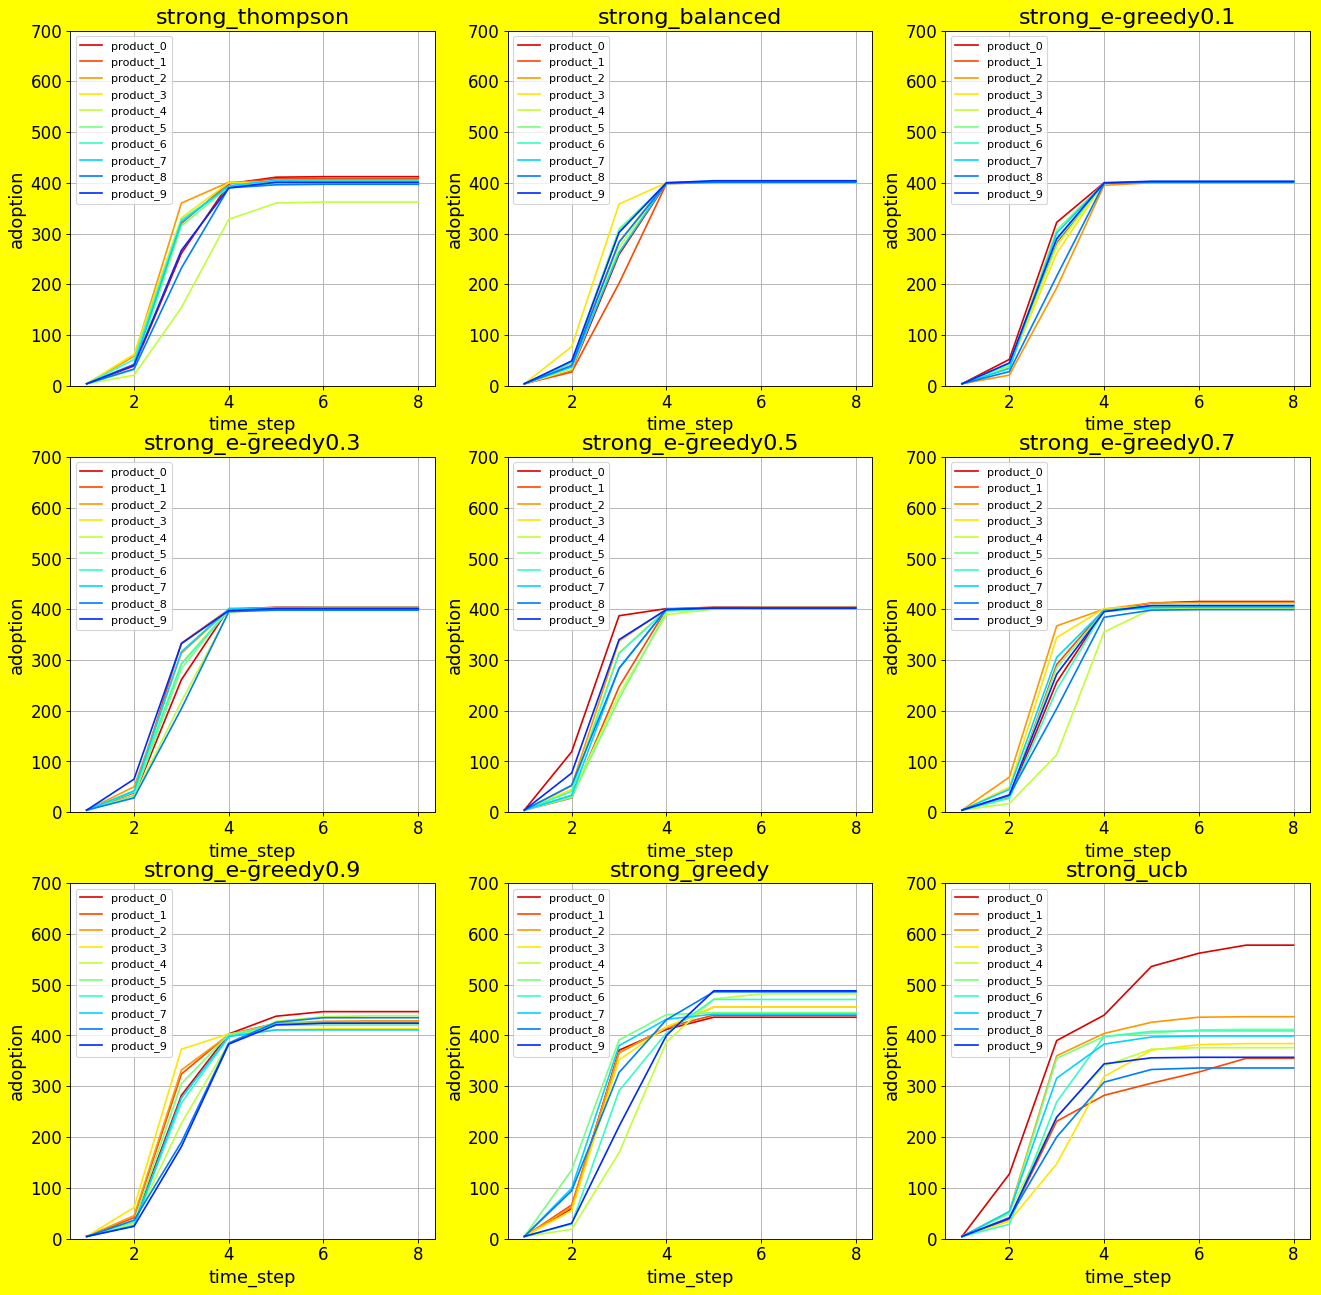

In [21]:
rearanged_keys = ['thompson', 'balanced', 'e-greedy0.1', 'e-greedy0.3', 
                  'e-greedy0.5', 'e-greedy0.7', 'e-greedy0.9', 'greedy', 'ucb']
plt.figure(num=3, figsize=(20, 20), dpi=80, facecolor='yellow', edgecolor='k')
product_count = 10
time_step = 8
subplt_count = 1
color_num = product_count+2
cmap = plt.get_cmap('jet_r')
overall_adopt_curve = {}
for policy in rearanged_keys:
    overall_adopt_curve[policy] = {}
    for product in range(product_count):
        overall_adopt_curve[policy][product] = []
for policy in rearanged_keys:
    for product in range(product_count):
        temp_sum = 0
        for cur_time in range(time_step):
            if  cur_time < len(overall_phase_adopted[policy][product]):
                temp_adopt = overall_phase_adopted[policy][product][cur_time]
            else:
                temp_adopt = 0
            overall_adopt_curve[policy][product].append(temp_sum + temp_adopt)
            temp_sum += temp_adopt
for policy in rearanged_keys:
    plt.subplot(3,3,subplt_count)
    plt.title(homo_deg+'_'+policy,fontsize = 20)
    color_count = 1
    for product in range(product_count):
        y_arr = overall_adopt_curve[policy][product]
        color = cmap(float(color_count)/color_num)
        plt.plot(range(1,time_step+1), y_arr, label='product_'+str(product), c = color)
        color_count += 1
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.legend(loc='upper left')
    plt.xlabel('time_step', fontsize = 16)
    plt.ylabel('adoption',fontsize = 16)
    plt.grid(True)
    axes = plt.gca()
    axes.set_ylim([0, 700])
    subplt_count += 1
    
plt.show()

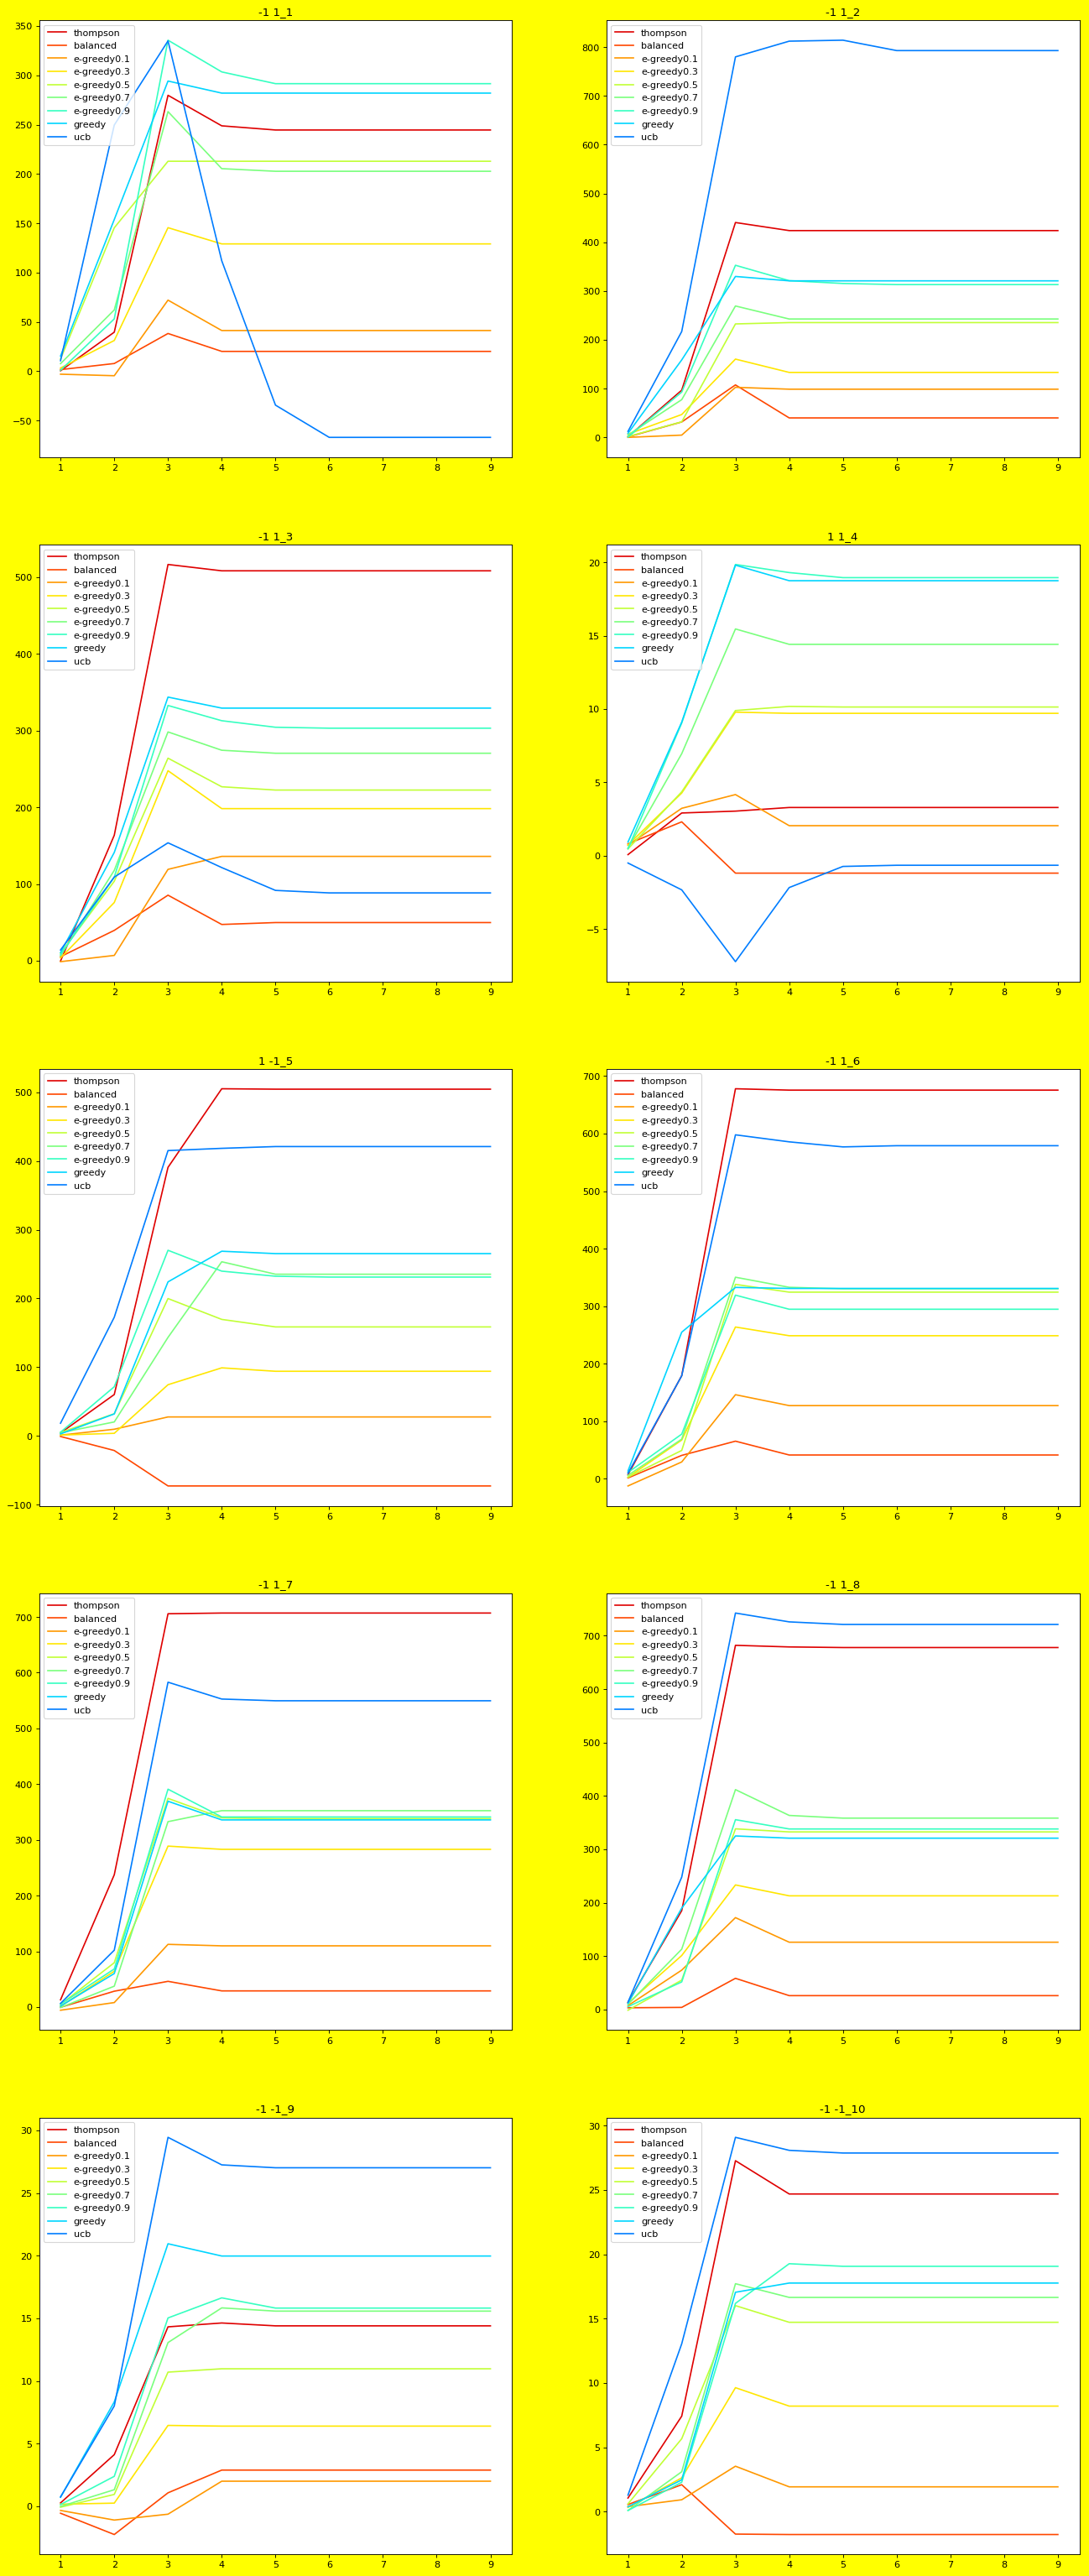

In [23]:
def obtain_accumulate(data_np):
    rows,cols = data_np.shape
    res_data = np.zeros((rows, cols))
    for i in range(rows):
        temp_sum = 0
        for j in range(cols):
            temp_sum += data_np[i,j]
            res_data[i, j] = temp_sum
    
    return res_data
fig = plt.figure(num=1, figsize=(20, 50), dpi=80, facecolor='yellow', edgecolor='k')
plt_count = 1
new_performance = {}
cmap = plt.get_cmap('jet_r')
overall_perform = overall_processed_res[0]

X_name_list = []
name_count = 1
# for X in Product_list:
#     X_name = ' '.join(str(e) for e in X) + '_' + str(name_count)
#     X_name_list.append(X_name)
#     name_count += 1
X_name_list = overall_perform['balanced'].keys()
for X_name in X_name_list:
    new_performance[X_name] = {}
    y = np.zeros((len(rearanged_keys), 9))
    x_count = 0
    for policy in rearanged_keys:
        new_performance[X_name][policy] = {}
        y_count = 0
        for time in range(1,8):
            if time < len(overall_perform[policy][X_name]):
                new_performance[X_name][policy][time] = overall_perform[policy][X_name][time]
            else:
                new_performance[X_name][policy][time] = 0
            y[x_count][y_count] = new_performance[X_name][policy][time]
            y_count += 1
        x_count += 1
    y = obtain_accumulate(y)
    labels = rearanged_keys
    ax = fig.add_subplot(5, 2, plt_count)
    ax.set_title(X_name)
    color_count = 1
    N = 12
    for y_arr, label in zip(y, labels):
        color = cmap(float(color_count)/N)
        plt.plot(range(1,10), y_arr, label=label, c = color)
        color_count += 1
    ax.legend(loc='upper left')
    plt_count += 1
plt.savefig('strong_process.jpg')
plt.show()

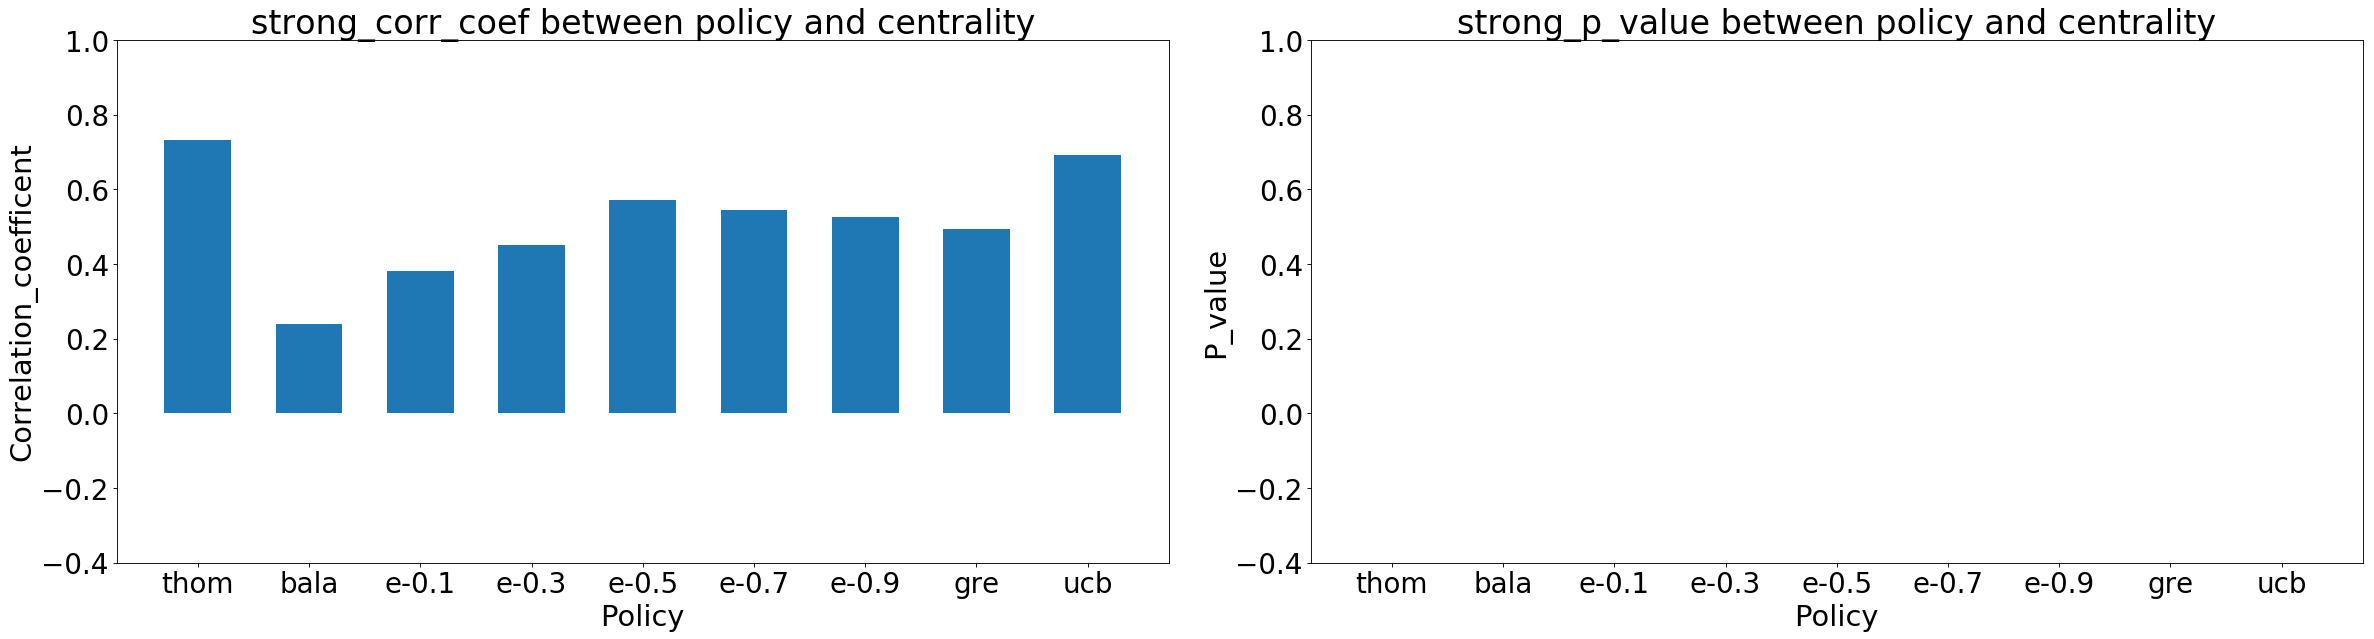

In [25]:
from scipy.stats import *
# Homo_degs = ['weak','2_medium','1_medium','medium','medium_1','medium_2','medium_3','strong']
Homo_degs = ['strong']
plot_keys = ['thom', 'bala', 'e-0.1', 'e-0.3', 'e-0.5', 'e-0.7', 'e-0.9', 'gre','ucb']
plt_count = 0
plt.figure(num=5, figsize=(30, 60), dpi=80, edgecolor='k')
pair_vects = overall_pair_vectors
for Homo_deg in Homo_degs:


    Pearson_analysis = {}
    network_name = 'network'
    for policy, vectors in pair_vects[0].items():
        if policy != network_name:
            Pearson_analysis[policy] = {}
            Pearson_analysis[policy]['Pearson_cor'] = []
            Pearson_analysis[policy]['P_value_2'] = []
    policies = list(Pearson_analysis.keys())
    count = 0
    for pair_vec in pair_vects:
#         if pref_dict[Homo_deg][count] == 0:
#             count += 1
#             continue
#         count += 1
        network_vector = np.squeeze(np.asarray(pair_vec[network_name]))
    #     print(network_vector)
        for policy in policies:
            pear_cor, p_val = pearsonr(network_vector, pair_vec[policy])
            Pearson_analysis[policy]['Pearson_cor'].append(pear_cor)
            Pearson_analysis[policy]['P_value_2'].append(p_val)
    new_performance = {}
    for policy in policies:
        new_performance[policy] = {}
        new_performance[policy]['cor_mean'] = np.mean(Pearson_analysis[policy]['Pearson_cor'])
        new_performance[policy]['cor_std'] = np.std(Pearson_analysis[policy]['Pearson_cor'])
        new_performance[policy]['p_mean'] = np.mean(Pearson_analysis[policy]['P_value_2'])
        new_performance[policy]['p_std'] = np.std(Pearson_analysis[policy]['P_value_2'])



    means = [new_performance[policy]['cor_mean'] for policy in rearanged_keys]
    std = [new_performance[policy]['cor_std'] for policy in rearanged_keys]
    ind = np.arange(len(new_performance.keys()))
    width = 0.6
    plt.figure(5)
    plt.subplot(8,2,1+plt_count)
    p1 = plt.bar(ind, means, width, yerr=std)
    plt.xticks(ind, plot_keys)
    plt.xlabel('Policy', fontsize = 26)
    plt.ylabel('Correlation_coefficent', fontsize = 26)
    plt.title(Homo_deg + "_corr_coef between policy and centrality", fontsize = 30)
    plt.tick_params(axis='both', which='major', labelsize=25)
    axes = plt.gca()
    axes.set_ylim([-0.4,1])

    means = [new_performance[policy]['p_mean'] for policy in rearanged_keys]
    std = [new_performance[policy]['p_std'] for policy in rearanged_keys]
    ind = np.arange(len(new_performance.keys()))
    plt.subplot(8,2,2+plt_count)
    p1 = plt.bar(ind, means, width, yerr=std)
    plt.xticks(ind, plot_keys)
    plt.title(Homo_deg + "_p_value between policy and centrality",fontsize = 30)
    plt.tick_params(axis='both', which='major', labelsize=25)
    plt.xlabel('Policy', fontsize = 26)
    plt.ylabel('P_value', fontsize = 26)
    plt_count += 2
    axes = plt.gca()
    axes.set_ylim([-0.4,1])


plt.tight_layout()
plt.show()


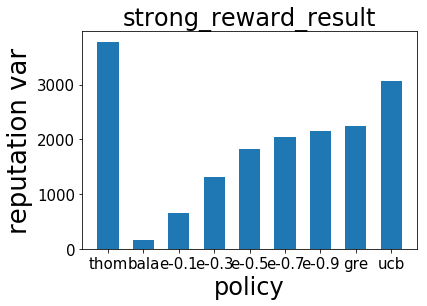

In [28]:
means = [overall_reward[policy] for policy in rearanged_keys]
std = [0 for policy in rearanged_keys]
ind = np.arange(len(new_performance.keys()))
width = 0.6
plt.figure()
plt.xlabel('policy',fontsize = 24)
plt.ylabel('reputation var',fontsize = 26)
plt.title('strong'+'_reward_result',fontsize = 24)
plt.tick_params(axis='both', which='major', labelsize=15)
p1 = plt.bar(ind, means, width, yerr=std)
plt.xticks(ind, plot_keys)
plt.show()

# Negative

In [60]:
pos_prods = np.random.choice(np.arange(len(Products['positive'])), int(X_number*0.2), replace=True).tolist()
pos_prods = [Products['positive'][i] for i in pos_prods]
neg_prods = np.random.choice(np.arange(len(Products['negative'])), int(X_number*0.8), replace=True).tolist()
neg_prods = [Products['negative'][i] for i in neg_prods]
X_list = pos_prods + neg_prods
print(X_list)
random.shuffle(X_list)
print(X_list)
Product_list = X_list

[[-1, 1], [-1, -1], [1, -1], [1, 1], [1, 1], [1, -1], [1, 1], [1, -1], [1, -1], [1, -1]]
[[1, 1], [-1, -1], [1, -1], [1, -1], [1, 1], [1, -1], [1, 1], [-1, 1], [1, -1], [1, -1]]


In [61]:
overall_phase_adopted = {}
overall_pair_vectors = []
overall_processed_res = []
overall_mse_list = []
overall_network_pref = []
policies = ['thompson','greedy', 'e-greedy','balanced', 'ucb']

temp_pair_vectors = {}
temp_process_result = {}
temp_mse_list = {}
eigen_central_vector = graph_eigen_centrality(Graph)
temp_pair_vectors['network'] = eigen_central_vector
for policy in policies:
    print(policy)
    if policy == 'e-greedy':
        for eps in eps_s:
            temp_mse_list[policy + str(eps)] = {}
            temp_process_result[policy + str(eps)] = {}
            new_graph = copy.deepcopy(Graph)
            new_adopted_node = copy.deepcopy(adopt_nodes)
            new_friend_pref = copy.deepcopy(friend_pref)
            # plt.subplot(161+count)
            # count += 1
            temp_reward, temp_reputation, temp_phase_adopted = plot_reward(individual_type='neutral',
                                                         policy=policy,
                                                         X_list = Product_list,
                                                         Graph=new_graph,
                                                         friend_est_pref=new_friend_pref,
                                                         adopted_node=new_adopted_node,
                                                         eps_greedy=eps,
                                                         time_step=8,
                                                         process_result=temp_process_result[policy+str(eps)],
                                                         pref_mse_list=temp_mse_list[policy + str(eps)])

            if len(temp_process_result[policy+str(eps)].keys()) == 0:
                print("process_result is None, Error!")
                exit(0)
            overall_phase_adopted[policy+str(eps)] = (temp_phase_adopted)
            temp_pair_vectors[policy+str(eps)] = np.array(list(temp_reward.values()))
            overall_reward[policy+str(eps)] = np.sum(list(temp_reward.values()))
    else:
        temp_process_result[policy] = {}
        temp_mse_list[policy + str(eps)] = {}
        new_graph = copy.deepcopy(Graph)
        new_adopted_node = copy.deepcopy(adopt_nodes)
        new_friend_pref = copy.deepcopy(friend_pref)
        temp_reward, temp_reputation, temp_phase_adopted = plot_reward(individual_type='neutral',
                                                     policy=policy,
                                                     X_list=Product_list,
                                                     Graph=new_graph,
                                                     friend_est_pref=new_friend_pref,
                                                     adopted_node=new_adopted_node,
                                                     time_step=8,
                                                     process_result=temp_process_result[policy],
                                                     pref_mse_list=temp_mse_list[policy + str(eps)])
        overall_phase_adopted[policy] = (temp_phase_adopted)
        overall_reward[policy] = np.sum(list(temp_reward.values()))
        temp_pair_vectors[policy] = np.array(list(temp_reward.values()))
overall_pair_vectors.append(temp_pair_vectors)
overall_processed_res.append(temp_process_result)
overall_mse_list.append(temp_mse_list)


thompson
greedy
e-greedy
balanced
ucb


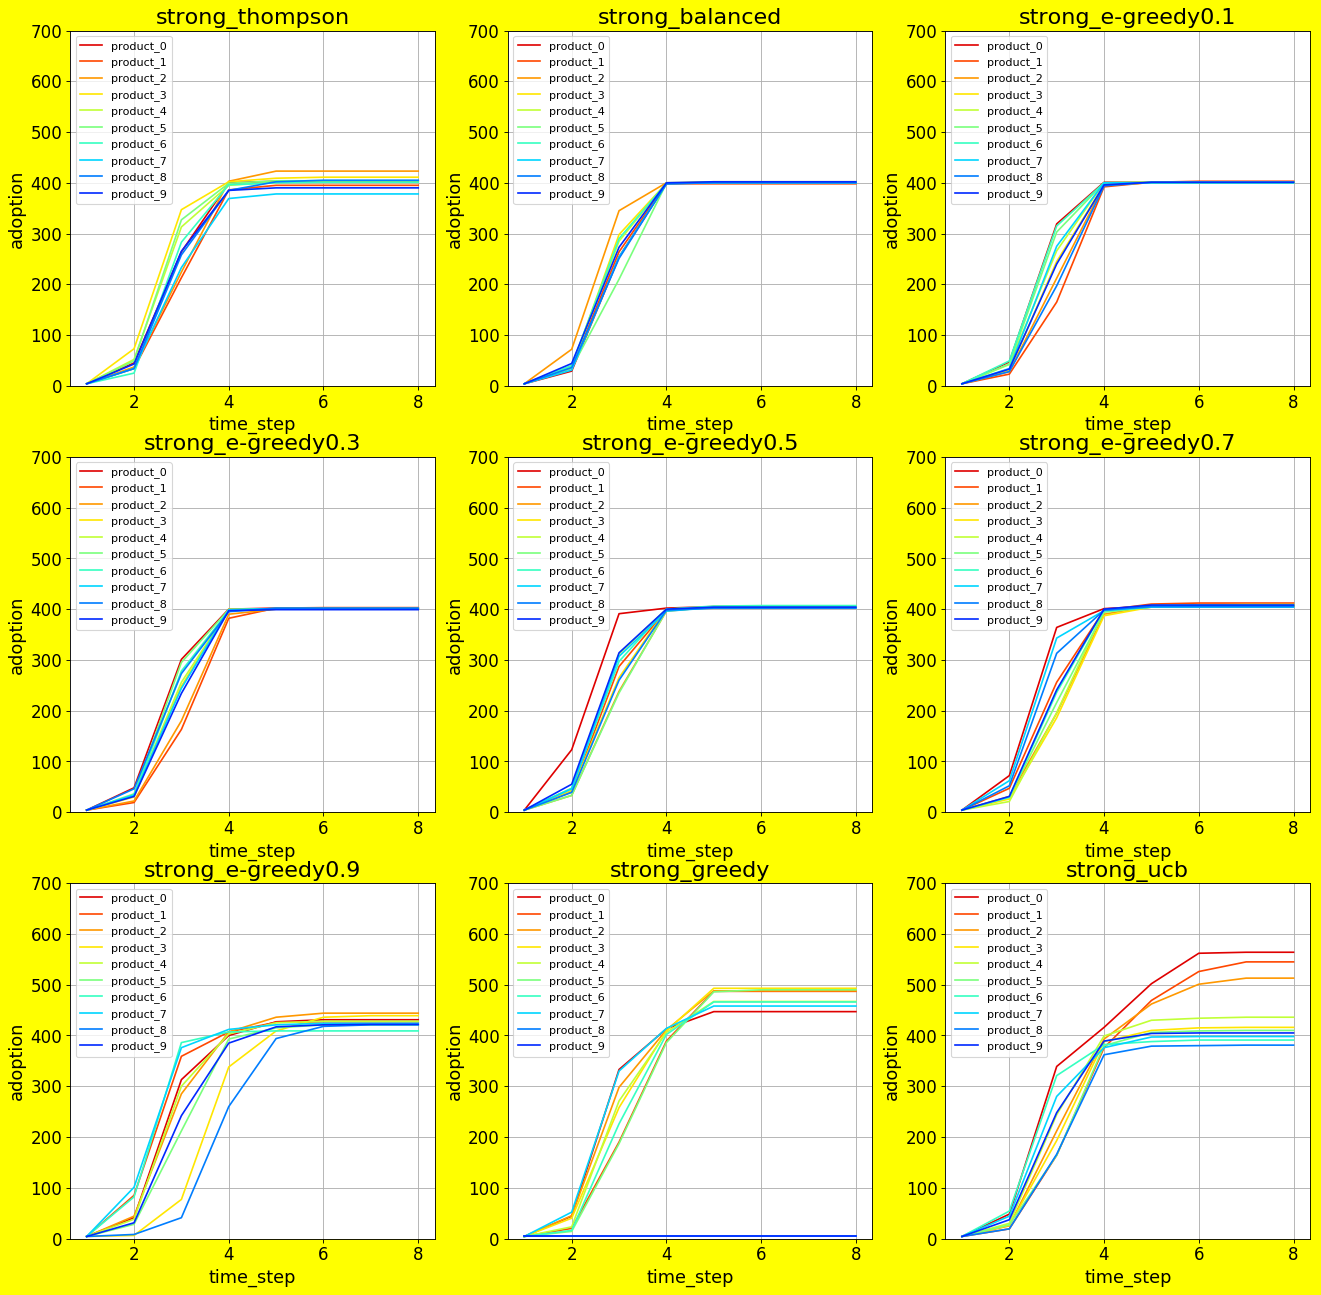

In [62]:
rearanged_keys = ['thompson', 'balanced', 'e-greedy0.1', 'e-greedy0.3', 
                  'e-greedy0.5', 'e-greedy0.7', 'e-greedy0.9', 'greedy', 'ucb']
plt.figure(num=3, figsize=(20, 20), dpi=80, facecolor='yellow', edgecolor='k')
product_count = 10
time_step = 8
subplt_count = 1
color_num = product_count+2
cmap = plt.get_cmap('jet_r')
overall_adopt_curve = {}
for policy in rearanged_keys:
    overall_adopt_curve[policy] = {}
    for product in range(product_count):
        overall_adopt_curve[policy][product] = []
for policy in rearanged_keys:
    for product in range(product_count):
        temp_sum = 0
        for cur_time in range(time_step):
            if  cur_time < len(overall_phase_adopted[policy][product]):
                temp_adopt = overall_phase_adopted[policy][product][cur_time]
            else:
                temp_adopt = 0
            overall_adopt_curve[policy][product].append(temp_sum + temp_adopt)
            temp_sum += temp_adopt
for policy in rearanged_keys:
    plt.subplot(3,3,subplt_count)
    plt.title(homo_deg+'_'+policy,fontsize = 20)
    color_count = 1
    for product in range(product_count):
        y_arr = overall_adopt_curve[policy][product]
        color = cmap(float(color_count)/color_num)
        plt.plot(range(1,time_step+1), y_arr, label='product_'+str(product), c = color)
        color_count += 1
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.legend(loc='upper left')
    plt.xlabel('time_step', fontsize = 16)
    plt.ylabel('adoption',fontsize = 16)
    plt.grid(True)
    axes = plt.gca()
    axes.set_ylim([0, 700])
    subplt_count += 1
    
plt.show()

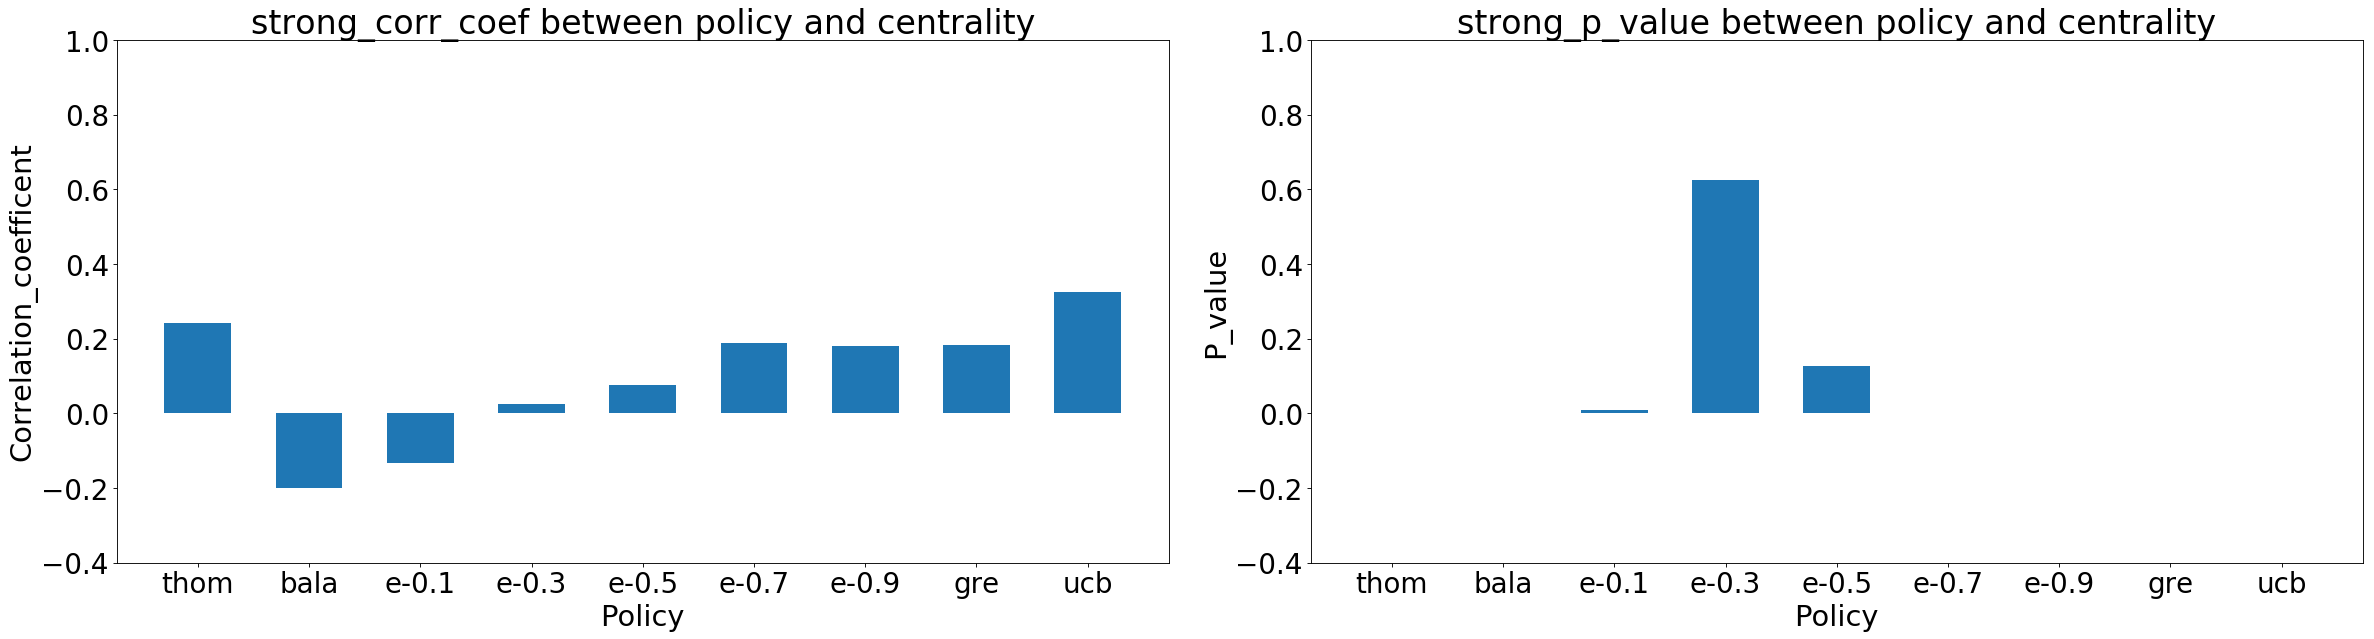

In [63]:
from scipy.stats import *
# Homo_degs = ['weak','2_medium','1_medium','medium','medium_1','medium_2','medium_3','strong']
Homo_degs = ['strong']
plot_keys = ['thom', 'bala', 'e-0.1', 'e-0.3', 'e-0.5', 'e-0.7', 'e-0.9', 'gre','ucb']
plt_count = 0
plt.figure(num=5, figsize=(30, 60), dpi=80, edgecolor='k')
pair_vects = overall_pair_vectors
for Homo_deg in Homo_degs:


    Pearson_analysis = {}
    network_name = 'network'
    for policy, vectors in pair_vects[0].items():
        if policy != network_name:
            Pearson_analysis[policy] = {}
            Pearson_analysis[policy]['Pearson_cor'] = []
            Pearson_analysis[policy]['P_value_2'] = []
    policies = list(Pearson_analysis.keys())
    count = 0
    for pair_vec in pair_vects:
#         if pref_dict[Homo_deg][count] == 0:
#             count += 1
#             continue
#         count += 1
        network_vector = np.squeeze(np.asarray(pair_vec[network_name]))
    #     print(network_vector)
        for policy in policies:
            pear_cor, p_val = pearsonr(network_vector, pair_vec[policy])
            Pearson_analysis[policy]['Pearson_cor'].append(pear_cor)
            Pearson_analysis[policy]['P_value_2'].append(p_val)
    new_performance = {}
    for policy in policies:
        new_performance[policy] = {}
        new_performance[policy]['cor_mean'] = np.mean(Pearson_analysis[policy]['Pearson_cor'])
        new_performance[policy]['cor_std'] = np.std(Pearson_analysis[policy]['Pearson_cor'])
        new_performance[policy]['p_mean'] = np.mean(Pearson_analysis[policy]['P_value_2'])
        new_performance[policy]['p_std'] = np.std(Pearson_analysis[policy]['P_value_2'])



    means = [new_performance[policy]['cor_mean'] for policy in rearanged_keys]
    std = [new_performance[policy]['cor_std'] for policy in rearanged_keys]
    ind = np.arange(len(new_performance.keys()))
    width = 0.6
    plt.figure(5)
    plt.subplot(8,2,1+plt_count)
    p1 = plt.bar(ind, means, width, yerr=std)
    plt.xticks(ind, plot_keys)
    plt.xlabel('Policy', fontsize = 26)
    plt.ylabel('Correlation_coefficent', fontsize = 26)
    plt.title(Homo_deg + "_corr_coef between policy and centrality", fontsize = 30)
    plt.tick_params(axis='both', which='major', labelsize=25)
    axes = plt.gca()
    axes.set_ylim([-0.4,1])

    means = [new_performance[policy]['p_mean'] for policy in rearanged_keys]
    std = [new_performance[policy]['p_std'] for policy in rearanged_keys]
    ind = np.arange(len(new_performance.keys()))
    plt.subplot(8,2,2+plt_count)
    p1 = plt.bar(ind, means, width, yerr=std)
    plt.xticks(ind, plot_keys)
    plt.title(Homo_deg + "_p_value between policy and centrality",fontsize = 30)
    plt.tick_params(axis='both', which='major', labelsize=25)
    plt.xlabel('Policy', fontsize = 26)
    plt.ylabel('P_value', fontsize = 26)
    plt_count += 2
    axes = plt.gca()
    axes.set_ylim([-0.4,1])


plt.tight_layout()
plt.show()


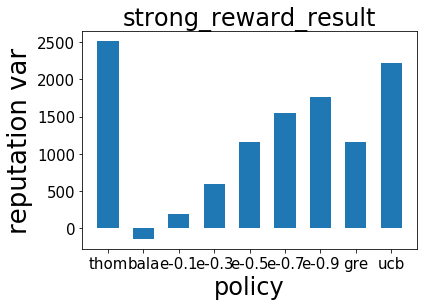

In [65]:
means = [overall_reward[policy] for policy in rearanged_keys]
std = [0 for policy in rearanged_keys]
ind = np.arange(len(new_performance.keys()))
width = 0.6
plt.figure()
plt.xlabel('policy',fontsize = 24)
plt.ylabel('reputation var',fontsize = 26)
plt.title('strong'+'_reward_result',fontsize = 24)
plt.tick_params(axis='both', which='major', labelsize=15)
p1 = plt.bar(ind, means, width, yerr=std)
plt.xticks(ind, plot_keys)
plt.show()

In [53]:
new_graph = copy.deepcopy(Graph)
new_adopted_node = copy.deepcopy(adopt_nodes)
new_friend_pref = copy.deepcopy(friend_pref)
temp_reward, temp_reputation, temp_phase_adopted = plot_reward(individual_type='neutral',
                                                             policy='e-greedy',
                                                             X_list = Product_list,
                                                             Graph=new_graph,
                                                             friend_est_pref=new_friend_pref,
                                                             adopted_node=new_adopted_node,
                                                             eps_greedy=0.3,
                                                             time_step=8,
                                                             process_result=temp_process_result['e-greedy0.9'],
                                                             pref_mse_list=temp_mse_list['e-greedy0.30.9'])

For time:  1 Current adopt node:  [269, 365, 161, 359]
For time:  2 Current adopt node:  [0, 16, 18, 285, 157, 311, 245, 13, 23, 58, 152, 40, 43, 1, 20, 87, 92, 293, 42, 52, 247]
For time:  3 Current adopt node:  [10, 11, 12, 17, 276, 24, 30, 300, 49, 68, 327, 338, 97, 101, 105, 116, 121, 381, 125, 151, 200, 214, 226, 232, 14, 15, 27, 35, 44, 333, 2, 4, 5, 7, 8, 9, 22, 31, 33, 41, 45, 48, 56, 65, 69, 93, 98, 111, 115, 120, 131, 134, 138, 142, 184, 189, 209, 212, 218, 228, 231, 246, 251, 260, 266, 290, 294, 298, 307, 323, 325, 336, 378, 3, 25, 28, 32, 37, 51, 57, 60, 61, 66, 67, 80, 96, 100, 102, 108, 122, 126, 128, 133, 139, 158, 164, 199, 234, 237, 244, 255, 263, 271, 292, 295, 309, 331, 335, 346, 347, 349, 368, 375, 384, 386, 397, 26, 39, 314, 316, 141, 155, 204, 230, 6, 34, 46, 77, 82, 88, 124, 160, 188, 197, 201, 252, 284, 297, 320, 328, 330, 348, 382, 399, 261, 267, 21, 291, 312, 64, 84, 369, 119, 146, 265, 50, 305, 315, 79, 81, 85, 95, 351, 354, 114, 374, 156, 270, 288, 306, 63, 

For time:  1 Current adopt node:  [53, 236, 127, 288]
For time:  2 Current adopt node:  [11, 14, 33, 294, 70, 345, 348, 128, 181, 203, 215, 237, 238, 256, 262, 269, 46, 49, 318, 205, 92, 225, 120, 122, 277, 44, 9, 15, 27]
For time:  3 Current adopt node:  [258, 261, 263, 10, 12, 17, 25, 304, 65, 71, 82, 350, 107, 371, 377, 386, 393, 170, 201, 207, 223, 242, 254, 0, 5, 6, 7, 8, 13, 18, 19, 20, 22, 23, 28, 29, 30, 42, 43, 45, 47, 48, 50, 52, 54, 55, 58, 68, 75, 79, 88, 108, 136, 146, 159, 166, 167, 174, 175, 196, 211, 220, 245, 247, 249, 290, 336, 357, 372, 373, 376, 380, 35, 37, 40, 78, 85, 96, 137, 148, 156, 163, 189, 190, 191, 282, 287, 302, 338, 340, 359, 383, 4, 21, 26, 31, 64, 72, 74, 91, 94, 118, 126, 133, 154, 168, 182, 183, 204, 235, 241, 246, 252, 330, 356, 362, 395, 396, 1, 274, 38, 41, 83, 355, 382, 389, 397, 147, 176, 187, 217, 219, 248, 251, 2, 36, 309, 57, 316, 69, 77, 335, 347, 99, 364, 109, 114, 124, 125, 387, 157, 160, 195, 210, 268, 34, 298, 314, 321, 81, 341, 89, 366,

For time:  1 Current adopt node:  [300, 385, 354, 182]
For time:  2 Current adopt node:  [4, 11, 27, 28, 30, 224, 101, 357, 2, 70, 150, 287, 100, 188, 317, 268, 399, 211, 149, 280, 25, 134, 7, 139, 13, 218, 95]
For time:  3 Current adopt node:  [262, 269, 19, 29, 31, 33, 44, 69, 360, 106, 113, 114, 369, 117, 120, 159, 187, 195, 198, 201, 214, 247, 252, 12, 14, 15, 17, 18, 21, 22, 39, 47, 66, 67, 76, 82, 83, 84, 89, 91, 102, 110, 124, 130, 140, 146, 183, 193, 203, 228, 251, 274, 282, 283, 295, 313, 338, 343, 348, 351, 362, 368, 377, 290, 37, 302, 306, 68, 86, 108, 128, 136, 138, 396, 147, 174, 178, 190, 233, 238, 0, 1, 3, 5, 8, 9, 10, 16, 32, 35, 38, 40, 45, 48, 49, 50, 52, 78, 79, 88, 92, 125, 166, 167, 185, 196, 205, 241, 245, 249, 301, 336, 373, 20, 24, 56, 65, 81, 115, 121, 176, 184, 189, 209, 212, 226, 229, 231, 266, 273, 294, 298, 307, 323, 325, 333, 346, 378, 26, 34, 80, 118, 119, 143, 145, 153, 164, 171, 180, 181, 192, 194, 200, 206, 210, 235, 286, 292, 299, 309, 344, 366, 375, 

In [56]:
policies

['thompson',
 'greedy',
 'e-greedy0.1',
 'e-greedy0.3',
 'e-greedy0.5',
 'e-greedy0.7',
 'e-greedy0.9',
 'balanced',
 'ucb']